# Third Deliverable -  Clustering using K-Means DBSCAN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans, DBSCAN

Import data from previous deliverable [headline, city, lat/longitude and countrycode] and remove any null values.

In [2]:
df = pd.read_csv('data/df4.csv', sep=';', header=0)

In [3]:
df = df[df['latitude'].notnull()]

In [4]:
df.reset_index(drop=True, inplace=True)

In [5]:
df

,headline,city,latitude,longitude,countrycode
0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR
4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US
...,...,...,...,...,...
607,Rumors about Rabies spreading in Jerusalem hav...,Jerusalem,31.76904,35.21633,IL
608,More Zika patients reported in Indang,Indang,14.19528,120.87694,PH
609,Suva authorities confirmed the spread of Rotav...,Suva,-18.14161,178.44149,FJ
610,More Zika patients reported in Bella Vista,Bella Vista,18.45539,-69.94540,DO


## Using K-Means Algorithm

Plotting the latitude and longitude on a scatter chart produces the below.

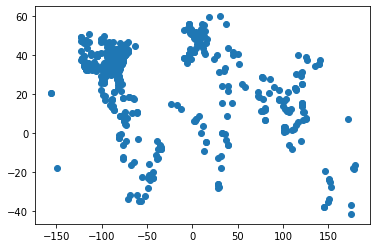

In [6]:
plt.scatter(df['longitude'],df['latitude'])

In [7]:
long = df['longitude'].to_list()
lat = df['latitude'].to_list()

locations = np.array(list(zip( long, lat)), dtype='float')
print(locations)

[[-80.19366  25.77427]
 [-74.00597  40.71427]
 [-80.13005  25.79065]
 ...
 [178.44149 -18.14161]
 [-69.9454   18.45539]
 [-98.49339  33.91371]]


### Using this array of locations we can plot the inertia over a set of K vales (1 to 10) and judge by eye a decent K value.

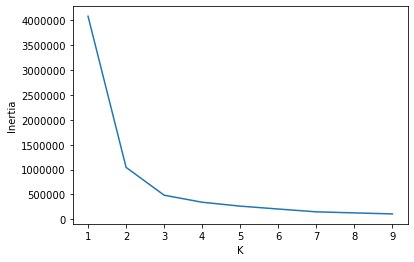

In [8]:
k_values = range(1, 10)
inertia_values = [KMeans(k).fit(locations).inertia_ for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

Our elbow points to 3.

###### Now re-plotting lat/long with 3 clusters yeilds...

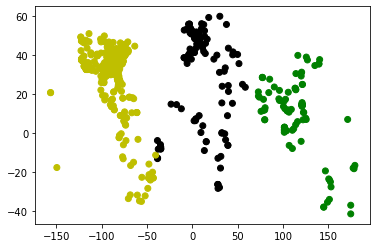

In [9]:
location_clusters = KMeans(3).fit_predict(locations)

colors = [['g', 'y', 'k'][cluster] for cluster in location_clusters]
plt.scatter(df['longitude'],df['latitude'], color=colors)
plt.show()

### Using DBSCAN with our locations 

In [10]:
def visualize_clusters(epsilon, min_points):
    dbscan_model = DBSCAN(eps=epsilon, min_samples=min_points)
    clusters = dbscan_model.fit_predict(locations)
    print(max(clusters)+1)
    #print(clusters)
    c = np.array(clusters)
    plt.scatter(df['longitude'],df['latitude'], c=c, cmap='gist_ncar')
    plt.show()
    return clusters

9


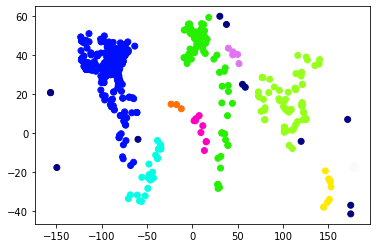

In [11]:
epsilon = 10
min_points = 3
clusters = visualize_clusters(epsilon, min_points)

I have settled on the values for eps = 10 and min points = 3

This seems so give better sampling across the continents and only has a few outliers.  You can clearly see that there is a divide between the america's, europe, asia and australasia.

Next we need add the cluster groups to the dataframe with the rest of our headline data.  The new column will be added to the end as 'cluster_index'.

## Adding the clusters to a world map using Basemap 

In [12]:
from mpl_toolkits.basemap import Basemap

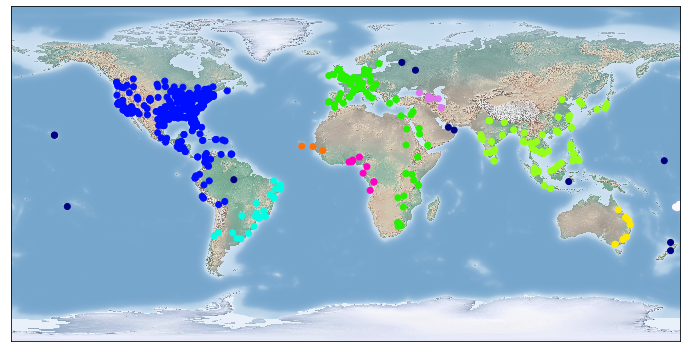

In [13]:
map_plotter = Basemap()
fig = plt.figure(figsize=(12, 8))
#map_plotter.drawcoastlines()
#map_plotter.drawcountries()
map_plotter.shadedrelief()
map_plotter.scatter(df['longitude'],df['latitude'], c=np.array(clusters), cmap='gist_ncar', latlon=True)
plt.show()

### Using the Great-Circle Distance as a Metric for DBSCAN

I will use the haversine formula for caluclating the great-circle distance

Haversine formula: 	
a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
c = 2 ⋅ atan2( √a, √(1−a) )
d = R ⋅ c
where 	φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
note that angles need to be in radians to pass to trig functions!

*source http://www.movable-type.co.uk/scripts/latlong.html

In [14]:
def great_circle_distance(location_a, location_b):
    delta_lat = (location_b[0]-location_a[0]) * np.pi/180
    delta_lon = (location_b[1]-location_a[1]) * np.pi/180
    R = 6371 # mean Earth radius in km
    a = (np.sin(delta_lat/2))**2 + (np.cos(location_a[0]*(np.pi/180)) * np.cos(location_b[0]*(np.pi/180)) * (np.sin(delta_lon/2))**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

example: distance between New York City and Miami in Kilometers (using first two headlines in df)

New York City
lat1 = 40.71427
lon1 = -74.00597

Miami
lat2 = 25.77427
lon2 = -80.19366

In [15]:
NewYork = np.array([40.71427, -74.00597])
Miami = np.array([25.77427, -80.19366])
print(f"The distance between New York and Miami is {great_circle_distance(NewYork, Miami):.2f} kilometers")

The distance between New York and Miami is 1756.84 kilometers


We should now be able to use this function as the metric argument for DBSCAN

In [16]:
clusters_gcd = DBSCAN(eps=1110, min_samples=7, metric=great_circle_distance).fit_predict(locations)

In [17]:
print(f"Number of Outliers: {(clusters_gcd == -1).sum()}")

Number of Outliers: 18


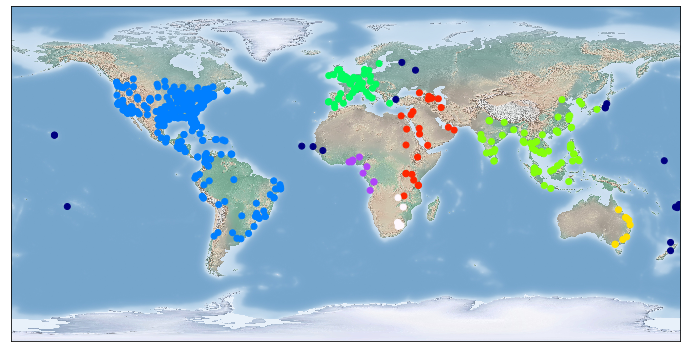

In [18]:
fig = plt.figure(figsize=(12, 8))
#map_plotter.drawcoastlines()
#map_plotter.drawcountries()
map_plotter.shadedrelief()
map_plotter.scatter(df['longitude'],df['latitude'], c=np.array(clusters_gcd), cmap='gist_ncar', latlon=True)
plt.show()

In [19]:
df = df.join(pd.DataFrame(clusters_gcd, columns=['cluster_index']))
df

,headline,city,latitude,longitude,countrycode,cluster_index
0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,US,0
1,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US,0
2,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR,0
4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US,0
...,...,...,...,...,...,...
607,Rumors about Rabies spreading in Jerusalem hav...,Jerusalem,31.76904,35.21633,IL,4
608,More Zika patients reported in Indang,Indang,14.19528,120.87694,PH,2
609,Suva authorities confirmed the spread of Rotav...,Suva,-18.14161,178.44149,FJ,-1
610,More Zika patients reported in Bella Vista,Bella Vista,18.45539,-69.94540,DO,0


In [20]:
df.to_csv('data/df5.csv', sep=';', index=False)